# Radiant Environment Maps

Radiant Environment Maps (REMs, also called "light-probes" or "skydomes" in different contexts) define the amount of light (radiance) travelling in all directions at a point in the Earth atmosphere. REMs can be computed using libRadtran with the radiance options ('umu' and 'phi') that allow specification of the directions in which one would like to compute the radiance. Most of the solvers in libRadtran can compute radiances, including all the variants of DISORT. One the basic capabilities in MORTICIA is to compute REMs and then to compute ("render") the appearance of targets in a specific radiant environment. This notebook illustrates the computation of REMs using libRadtran.

libRadtran has a number of k-distribution (also called "correlated-k") atmospheric absorption parametrizations. These models allow for more rapid computation of radiances and irradiances, but with limited spectral resolution. One such model for the shortwave spectrum is that by Kato et. al. For the thermal spectrum, there is the Fu parametrization. Read the libRadtran manual for more details. Here, we will use the Kato model to compute the sky/ground appearance as provided by a REM.

The MORTICIA class used for REM computation is morticia.rad.librad.RadEnv.

In [27]:
import morticia.rad.librad as librad
# Use auto reload of librad for development purposes
%load_ext autoreload
%autoreload 1
%aimport morticia.rad.librad
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from ipyparallel import Client  # This is the client class for contacting the hub/controller

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [145]:
# Load a libRadtran example case
# Be default, any include files are expanded, creating a single set of option keywords
libRadCase=librad.Case(filename='./examples/UVSPEC_AEROSOL_1WVL.INP')
libRadCase.alter_option(['albedo', '0.5'])

In [146]:
# Build a radiant environment map case
libRadEnv = librad.RadEnv(base_case=libRadCase, n_pol=256, n_azi=256, hemi=True)

In [120]:
paraclient = Client(profile='icebow', sshserver='dgriffith@146.64.246.95', password='dgIceBow')

In [121]:
paraclient[:].use_dill()

<AsyncResult: use_dill>

In [122]:
# Obtain a "load-balanced" view of the engine cluster
paraview = paraclient.load_balanced_view()
# Set the view to blocking mode, which means that we wait for all engines to complete the task before
# control is returned to the client
paraview.block = True

In [147]:
libRadEnv.run_ipyparallel(ipyparallel_view=paraview)

In [129]:
libRadEnv.uu.shape

(256L, 256L, 21L, 1L, 1L)

In [ ]:
from itertools import chain

In [ ]:
cc = list(chain(*libRadEnv.cases))

In [ ]:
cc[3].alter_option(['sza','0.555'])

In [ ]:
cc[3]

In [ ]:
libRadEnv.cases[1][1]

In [ ]:
np.append([1,2], [3,4])

In [87]:
xd_uu = xray.concat([xray.concat([case_uu.xd_uu for case_uu in libRadEnv.cases[jj]], dim='phi') 
                     for jj in range(len(libRadEnv.cases))], dim='umu')

In [89]:
len(libRadEnv.cases)

3

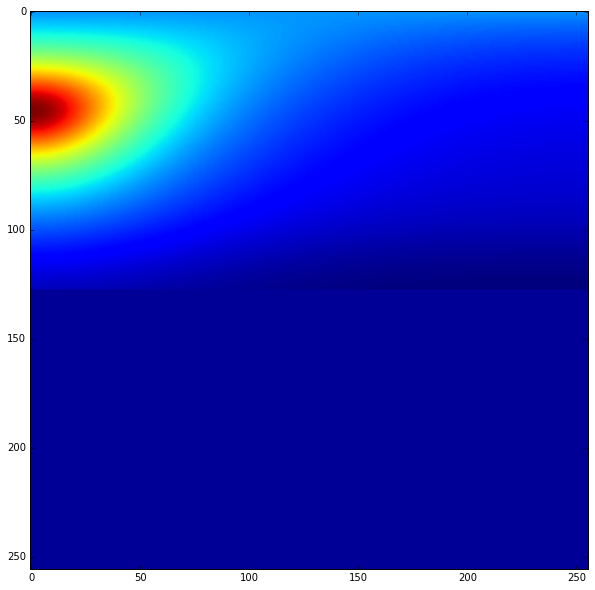

In [148]:
plt.figure(figsize=(10,10))
plt.imshow(libRadEnv.xd_uu[:,:,-1,0,0])

In [141]:
libRadEnv.xd_uu.dims

('umu', 'phi', 'wvl', 'zout', 'stokes')

In [142]:
libRadEnv.cases[0][0].name

'UVSPEC_AEROSOL__0000_0000'

In [144]:
libRadCase.name

'UVSPEC_AEROSOL_1WVL'